In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import patches

In [6]:
df = pd.read_csv("features/330 minute 1_features.csv")
df = df.set_index('frame number')

In [165]:
df.iloc[:, 8:].head()

,A_x,A_y,B_x,B_y,C_x,C_y,dist_A_left,dist_A_top,dist_A_right,dist_A_bottom,dist_A_center,dist_B_left,dist_B_top,dist_B_right,dist_B_bottom,dist_B_center
frame number,,,,,,,,,,,,,,,,
1,311.5,281.5,324.5,211.5,318.00,246.5,186.5,265.5,416.5,170.5,57.740125,199.5,195.5,403.5,240.5,39.231740
2,314.5,271.5,322.5,201.5,318.50,236.5,189.5,255.5,413.5,180.5,51.703274,197.5,185.5,405.5,250.5,43.760529
3,317.0,261.5,321.0,189.5,319.00,225.5,192.0,245.5,411.0,190.5,46.769735,196.0,173.5,407.0,262.5,49.269328
4,319.5,249.5,317.0,178.5,318.25,214.0,194.5,233.5,408.5,202.5,42.300044,192.0,162.5,411.0,273.5,57.469108
5,322.0,237.0,310.5,167.0,316.25,202.0,197.0,221.0,406.0,215.0,39.004504,185.5,151.0,417.5,285.0,68.596053


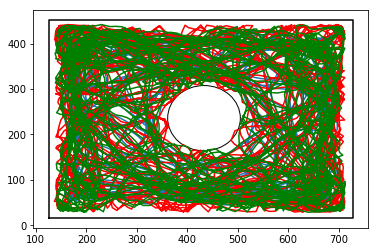

In [18]:
%matplotlib inline
plt.plot(df.C_x.values, df.C_y.values,'-')
plt.plot(df.A_x.values, df.A_y.values,'-r')
plt.plot(df.B_x.values, df.B_y.values,'-g')
# plot surrounding box
plt.plot([125, 728, 728, 125, 125],[16, 16, 452, 452, 16], 'k-')
# plot mid circle
circ = plt.Circle((433,236),72,color='k', fill=False)
plt.gca().add_patch(circ)

In [19]:
import random

def fetch_one_sample(df, ind, n_train_frames, n_label_frames, train_features, label_features):
    train = df.iloc[ind:ind + n_train_frames].loc[:, train_features].values.reshape(1, (n_train_frames) * len(train_features)) 
    labels = df.iloc[ind + n_train_frames:ind + n_train_frames + n_label_frames].loc[:, label_features].values.reshape(1, (n_label_frames) * len(label_features)) 
    return train, labels

def split_all_videos(n_train_frames, n_label_frames):
    train_all = None
    label_all = None
    train_features=['C_x','C_y']    
    label_features=['C_x','C_y']
    for filename in os.listdir('features'):
        
        if filename.endswith(".csv"):
            df = pd.read_csv("features/"+filename)
            df = df.reset_index(drop = True)
            total_len = n_train_frames + n_label_frames
            len = df.shape[0]
            index = 0
            while index + total_len < len:
                train, label = fetch_one_sample(df, index, n_train_frames, n_label_frames, train_features, label_features)
                if train_all is None:
                    train_all = train
                    label_all = label
                else:
                    train_all = np.vstack((train_all, train))
                    label_all = np.vstack((label_all, label))
#                 print("index {}".format(index))
                index += total_len
    
    train_index = pd.MultiIndex.from_product([range(n_train_frames), train_features])
    train_df = pd.DataFrame(train_all, columns = train_index)

    label_index = pd.MultiIndex.from_product([range(n_label_frames), label_features])
    label_df = pd.DataFrame(label_all, columns = label_index)

    return train_df, label_df

def split_all_videos_random(num_items, n_train_frames, n_label_frames):
    train_features=['C_x','C_y']
    label_features=['C_x','C_y']
    train_all = None
    label_all = None
    dfs = []
    total_len = n_train_frames + n_label_frames
    for filename in os.listdir('features'):
        if filename.endswith(".csv"):
            df = pd.read_csv("features/"+filename)
            dfs.append(df)
    for i in range(num_items):
        df = random.choice(dfs)
        len = df.shape[0]
        index = random.randint(0, len-total_len)
        train, label = fetch_one_sample(df, index, n_train_frames, n_label_frames, train_features, label_features)
        if train_all is None:
            train_all = train
            label_all = label
        else:
            train_all = np.vstack((train_all, train))
            label_all = np.vstack((label_all, label))

    train_index = pd.MultiIndex.from_product([range(n_train_frames), train_features])
    train_df = pd.DataFrame(train_all, columns = train_index)

    label_index = pd.MultiIndex.from_product([range(n_label_frames), label_features])
    label_df = pd.DataFrame(label_all, columns = label_index)

    return train_df, label_df
        
# train_all, label_all = split_all_videos(19, 1)
train_all, label_all = split_all_videos_random(10, 19, 1)
# train_all.head()
label_all.head()

0       
      C_x    C_y
0  168.50   61.0
1  661.75  280.0
2  679.50   64.5
3  392.00  367.0
4  296.00  411.5

In [186]:
def get_ordered_X_y(df, n_train_frames, n_label_frames):
    n_frames = (n_train_frames + n_label_frames)
    n_samples = df.shape[0] // n_frames
    n_features = df.shape[1]
    mat = df.loc[:n_samples * n_frames, :].values.reshape((n_samples, n_frames * n_features))
    X = mat.T[:-n_features,:].T
    y = mat.T[-n_features:,:].T
    y = y[:, 12:14] # for now, take only the centroid location as labels.
    return X, y

def get_random_X_y(df, n_samples=300, frames_to_train=20, frames_to_predict=1):
    n_features = len(df.columns)
    frames = (n_train + n_test) * 2


X, y = get_ordered_X_y(df.iloc[:,8:], 19, 1)
print(X.shape, y.shape)
    

ValueError: cannot reshape array of size 12560 into shape (314,2)

In [189]:
n_frames = (19 + 1)
n_samples = df.shape[0] // n_frames
n_features = df.shape[1]
df.loc[:n_samples * n_frames, ['C_x', 'C_y']].values.shape

(6280, 2)

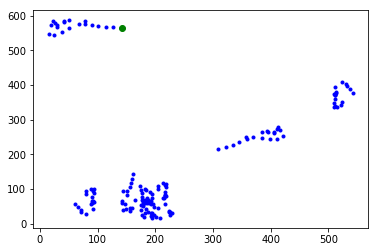

In [185]:
def show_train_test_preds(ind, preds):
    plot = plt.plot(X[ind-1:ind, 0::2], X[ind-1:ind, 1::2], 'b.', y[ind-1:ind, 0::2], y[ind-1:ind, 1::2], 'go',  preds[ind-1:ind, 0::2], preds[ind-1:ind, 1::2], 'ro')
    return plot


def show_train_test(df, ind, train_frames, test_frames):
    plot = plt.plot(X[ind-1:ind, 0::2], X[ind-1:ind, 1::2], 'b.', y[ind-1:ind, 0::2], y[ind-1:ind, 1::2], 'go')
    return plot

show_train_test(30);

In [167]:
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split


def rmse(preds, y):
    return np.sqrt(np.mean((preds-y)**2))


def regressor(model, X, y, X_test, y_test):
    t0 = time.time()
    model.fit(X, y)
    score = rmse(model.predict(X), y)
    test_score = rmse(model.predict(X_test), y_test)
    t1 = time.time()
    print("Model trained ({} seconds). Train score: {}, test score: {}".format(t1-t0, score, test_score))
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print("RF")
rf = regressor(RandomForestRegressor(n_estimators=500), 
               X_train, y_train, X_test, y_test)
print("Ridge")
ridge = regressor(Ridge(), 
                  X_train, y_train, X_test, y_test)
print("Linear Regression")
LR = regressor(LinearRegression(), 
                  X_train, y_train, X_test, y_test)

RF
Model trained (13.325051069259644 seconds). Train score: 7.790062174672226, test score: 19.844266379758
Ridge
Model trained (0.007999658584594727 seconds). Train score: 3.2874721634444493, test score: 6.262216912537541
Linear Regression
Model trained (0.012000322341918945 seconds). Train score: 3.323811233046511, test score: 6.35928398745195


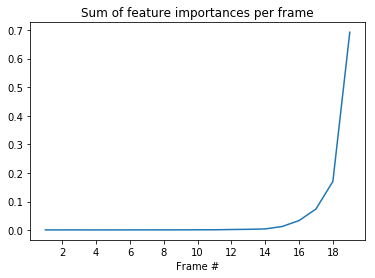

In [169]:
from matplotlib.ticker import MaxNLocator
plt.plot(np.arange(1,20), rf.feature_importances_.reshape(19,16).sum(axis=1))
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Frame #")
plt.title("Sum of feature importances per frame")

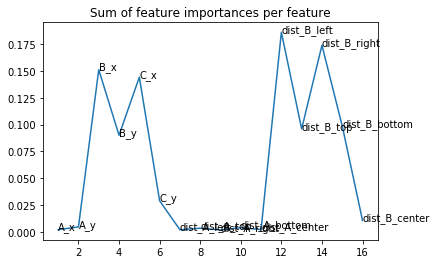

In [181]:
from matplotlib.ticker import MaxNLocator
xs = np.arange(1,17)
ys = rf.feature_importances_.reshape(19,16).sum(axis=0)
plt.plot(xs, ys)
ax = plt.gca()
for i, txt in enumerate(df.iloc[:,8:].columns):
    ax.annotate(txt, (xs[i],ys[i]))
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xlabel("Feature #")
# plt.gca().set_xticklabels(df.iloc[:,8:].columns[::2])
plt.title("Sum of feature importances per feature")

In [173]:
df.iloc[:,8:].columns[15]

'dist_B_center'

# results using C_x, C_y only as features
ordered samples, 1 movie  
n_train_frames=19  
n_test_frames=1  
**RF (n_estimators=500)**  
Model trained (2.5484297275543213 seconds). Train score: 7.1290825838968095, test score: 11.514212490530277  
**Ridge**  
Model trained (0.04400348663330078 seconds). Train score: 2.8489899146736204, test score: 19.901146078544908  
**Linear Regression**  
Model trained (0.05202293395996094 seconds). Train score: 2.8489808147245377, test score: 19.901146078544908
# results using all features
ordered samples, 1 movie  
n_train_frames=19  
n_test_frames=1  
RF  
Model trained (13.325051069259644 seconds). Train score: 7.790062174672226, test score: 19.844266379758  
Ridge  
Model trained (0.007999658584594727 seconds). Train score: 3.2874721634444493, test score: 6.262216912537541  
Linear Regression  
Model trained (0.012000322341918945 seconds). Train score: 3.323811233046511, test score: 6.35928398745195